### Load functions and environment

In [1]:
# The helper functions

from IPython import get_ipython
import random
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
from environment_add import TaskEnv
from typing import Tuple, List
import itertools as it
import numpy as np
import pandas as pd
import plotly.express as px
import statistics as s
from scipy.ndimage.filters import gaussian_filter1d


env = TaskEnv(frequencies_file="frequencies.csv")

C:\Users\User\AppData\Local\Temp\ipykernel_3360\3548424525.py:15: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d
c:\Users\User\Workspace\work_ppm_aggressive_incidents\BAIBart-Final\environment_add.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step

### Implementing the agents


In [2]:
# Random agent
class RandomAgent():
    def __init__(self,
                 env: TaskEnv,
                 exploration_rate: float = None,
                 learning_rate: float = None,
                 discount_factor: float = None) -> int:
        self.epsilon = 1  # A random agent "explores" always, so epsilon will be 1
        self.alpha = 0  # A random agent never learns, so there's no need for a learning rate
        self.gamma = 0  # A random agent does not update it's q-table. Hence, it's zero.
        self.q_table = np.zeros(env.observation_space.shape + (env.action_space.n, ), dtype=float)
        self.actions = env.action_space

    def select_action(self, state: Tuple[int, int], use_greedy_strategy: bool = False) -> int:
        if not use_greedy_strategy:
            if random.random() < self.epsilon:
                next_action = self.actions.sample()
                return next_action

        x, y = state
        max_val = np.max(self.q_table[x, y, :])
        find_max_val = np.where(self.q_table[x, y, :] == max_val)
        next_action = np.random.choice(find_max_val[0])
        return next_action

    def learn(self, state, action, next_state, reward, done):
        return None


In [3]:
# Implement two agents
# The Random_agent class above was used as a template, meaning that the initialization and select_action are kept
# The learn function has been implemented by us

# Q_learning agent uses an off-policy update rule, namely using the value of best action in the next state
class Q_learning_Agent():
    def __init__(self,
                 env: TaskEnv,
                 exploration_rate: float = 0.1,
                 learning_rate: float = 0.2,
                 discount_factor: float = 1) -> int:
        self.epsilon = exploration_rate  # A random agent "explores" always, so epsilon will be 1
        self.alpha = learning_rate  # A random agent never learns, so there's no need for a learning rate
        self.gamma = discount_factor  # A random agent does not update it's q-table. Hence, it's zero.
        self.q_table = np.zeros((4,7), dtype=float)
        self.actions = env.action_space

    def select_action(self, state, use_greedy_strategy: bool = False) -> int:
        if not use_greedy_strategy:
            if random.random() < self.epsilon:
                next_action = self.actions.sample()
                return next_action

        x = env.observation_space.columns.to_list().index(state)
        max_val = np.max(self.q_table[x, :])
        find_max_val = np.where(self.q_table[x, :] == max_val)
        next_action = np.random.choice(find_max_val[0])
        return next_action

    def learn(self, state, action, next_state, reward, done):        
        # Helper variables to easily get the indices of the value
        x = env.observation_space.columns.to_list().index(state)
        next_max_val = 0
        if next_state != 'Tau':
            x_ = env.observation_space.columns.to_list().index(next_state)
            # Get the maximum value
            next_max_val = np.max(self.q_table[x_, :])
        # Update the value in the q-table using Q(S,A) <- Q(S,A) + alpha(R + gamma(max action value) - Q(S,A))
        self.q_table[x, action] += self.alpha * (reward + (self.gamma*next_max_val) - self.q_table[x, action])

# SARSA uses an on-policy update rule, meaning it uses it behaviour policy to update the values in its q-table  
class SARSA_Agent():
    def __init__(self,
                 env: TaskEnv,
                 exploration_rate: float = 0.1,
                 learning_rate: float = 0.2,
                 discount_factor: float = 1) -> int:
        self.epsilon = exploration_rate  # A random agent "explores" always, so epsilon will be 1
        self.alpha = learning_rate  # A random agent never learns, so there's no need for a learning rate
        self.gamma = discount_factor  # A random agent does not update it's q-table. Hence, it's zero.
        self.q_table = np.zeros((4,7), dtype=float)
        self.actions = env.action_space

    def select_action(self, state, use_greedy_strategy: bool = False) -> int:
        if not use_greedy_strategy:
            if random.random() < self.epsilon:
                next_action = self.actions.sample()
                return next_action

        x = env.observation_space.columns.to_list().index(state)
        max_val = np.max(self.q_table[x, :])
        find_max_val = np.where(self.q_table[x, :] == max_val)
        next_action = np.random.choice(find_max_val[0])
        return next_action

    def learn(self, state, action, next_state, reward, done):
        x = env.observation_space.columns.to_list().index(state)
        next_val = 0
        if next_state != 'Tau':
            x_ = env.observation_space.columns.to_list().index(next_state)
            # Select the next action based on the next state and its own behaviour policy
            next_action = self.select_action(next_state)
            # Get the value associated with the action
            next_val = self.q_table[x_, next_action]
        # Update the q-value with the value obtained above
        self.q_table[x, action] += self.alpha * (reward + (self.gamma*next_val) - self.q_table[x, action])

### Run test

In [4]:
# Run the simulation for random learner
def run_random(nrofepisodes, inform=False):
    random_learner = RandomAgent(env)
    state = env.reset()

    information = {}
    rewards_ = []

    for _ in range(nrofepisodes):
        terminated = False
        sumRreward = 0
        while not terminated:
            action = random_learner.select_action(state)
            
            if inform:
                observation, reward, terminated, info = env.step(action, inform)
                if info != []:
                    key = ''.join(str(x) for x in info)
                    if key not in information:
                        information[key] = 1
                    else:
                        information[key] += 1
            else:
                observation, reward, terminated, info = env.step(action)            
            
            sumRreward += reward

            random_learner.learn(state, action, observation, reward, terminated)    
            
            state = observation

        state = env.reset()
        rewards_.append(sumRreward)
    return random_learner, rewards_, information


#test = run_random(10000)

In [5]:
def run_policy(nrofepisodes, inform=False):
    state = env.reset()
    
    information = {}
    rewards_ = []
    
    for _ in range(nrofepisodes):
        terminated = False
        sumRreward = 0
        while not terminated:
            action = 1
            
            if inform:
                observation, reward, terminated, info = env.step(action, inform)
                if info != []:
                    key = ''.join(str(x) for x in info)
                    if key not in information:
                        information[key] = 1
                    else:
                        information[key] += 1
            else:
                observation, reward, terminated, info = env.step(action)
            
            
            sumRreward += reward
            
            state = observation

        state = env.reset()
        rewards_.append(sumRreward)
    return rewards_, information

In [6]:
# Run the simulation for Q_learning
def run_qlearner(nrofepisodes, gamma, epsilon = 0.1, alpha=0.2, train = True, agent = None, inform=False):
    if agent == None:
        Q_learner = Q_learning_Agent(env, discount_factor=gamma, exploration_rate=epsilon, learning_rate=alpha)
    else:
        Q_learner = agent
    state = env.reset()

    information = {}
    
    rewards_ = []

    for _ in range(nrofepisodes):
        terminated = False
        sumRreward = 0
        while not terminated:
            if train:
                action = Q_learner.select_action(state)
            else:
                action = Q_learner.select_action(state, use_greedy_strategy=True)

            if inform:
                observation, reward, terminated, info = env.step(action, inform)
                if info != []:
                    key = ''.join(str(x) for x in info)
                    if key not in information:
                        information[key] = 1
                    else:
                        information[key] += 1
            else:
                observation, reward, terminated, info = env.step(action)
            
            sumRreward += reward
            
            if train:
                Q_learner.learn(state, action, observation, reward, terminated)    
            
            state = observation

        state = env.reset()
        rewards_.append(sumRreward)
    return Q_learner, rewards_, information

In [7]:
# Run the simulation for SARSA
def run_sarsa(nrofepisodes, gamma, epsilon = 0.1, alpha=0.2, train = True, agent = None, inform=False):
    # Train a new learner or not depending on if training or not
    if agent == None:
        SARSA_learner = SARSA_Agent(env, discount_factor=gamma, exploration_rate=epsilon, learning_rate=alpha)
    else:
        SARSA_learner = agent
        
    state = env.reset()
    information = {}
    rewards_ = []

    for _ in range(nrofepisodes):
        terminated = False
        sumRreward = 0
        while not terminated:
            # Follow policy to train or use best action learned
            if train:
                action = SARSA_learner.select_action(state)
            else:
                action = SARSA_learner.select_action(state, use_greedy_strategy=True)
            
            if inform:
                observation, reward, terminated, info = env.step(action, inform)
                if info != []:
                    key = ''.join(str(x) for x in info)
                    if key not in information:
                        information[key] = 1
                    else:
                        information[key] += 1
            else:
                observation, reward, terminated, info = env.step(action)
            
            sumRreward += reward
            # Only train if in learning process
            if train:
                SARSA_learner.learn(state, action, observation, reward, terminated)    
            
            state = observation

        state = env.reset()
        rewards_.append(sumRreward)
        
    return SARSA_learner, rewards_, information

 ### Hypertuning agents


In [8]:
# Find good epsilon for sarsa and extended sarsa
# searchspace epsilon: 0.01, 0.1, 0.3
episodesT = 10000
runs = 100
episodes = 2000

rS02, rS04, rS06, rS08, rS1 = np.empty((episodes, runs)), np.empty((episodes, runs)), np.empty((episodes, runs)) , np.empty((episodes, runs)) , np.empty((episodes, runs))
agent1, agent2, agent3 = run_qlearner(episodesT, 0.2, epsilon=0.1, alpha=0.1)[0], run_qlearner(episodesT, 0.2, epsilon=0.1, alpha=0.1)[0], run_qlearner(episodesT, 0.2, epsilon=0.1, alpha=0.1)[0]

'''
for i in tqdm(range(runs)):
    rS02[:, i] = run_qlearner(episodes, 0.2, epsilon=0.1, alpha=0.1)[1]
    rS04[:, i] = run_qlearner(episodes, 0.2, epsilon=0.1, alpha=0.2)[1]
    rS06[:, i] = run_qlearner(episodes, 0.2, epsilon=0.1, alpha=0.3)[1]
    rS08[:, i] = run_qlearner(episodes, 0.2, epsilon=0.1, alpha=0.4)[1]
    rS1[:, i] = run_qlearner(episodes, 0.2, epsilon=0.1, alpha=0.5)[1]

data_eps = {'Epsilon=0.1': np.apply_along_axis(np.mean, 1, rS02), 
            'Epsilon=0.2': np.apply_along_axis(np.mean, 1, rS04), 
            'Epsilon=0.3': np.apply_along_axis(np.mean, 1, rS06), 
            'Epsilon=0.4': np.apply_along_axis(np.mean, 1, rS08),
            'Epsilon=0.5': np.apply_along_axis(np.mean, 1, rS1)}
df_eps = pd.DataFrame(data=data_eps)
'''

"\nfor i in tqdm(range(runs)):\n    rS02[:, i] = run_qlearner(episodes, 0.2, epsilon=0.1, alpha=0.1)[1]\n    rS04[:, i] = run_qlearner(episodes, 0.2, epsilon=0.1, alpha=0.2)[1]\n    rS06[:, i] = run_qlearner(episodes, 0.2, epsilon=0.1, alpha=0.3)[1]\n    rS08[:, i] = run_qlearner(episodes, 0.2, epsilon=0.1, alpha=0.4)[1]\n    rS1[:, i] = run_qlearner(episodes, 0.2, epsilon=0.1, alpha=0.5)[1]\n\ndata_eps = {'Epsilon=0.1': np.apply_along_axis(np.mean, 1, rS02), \n            'Epsilon=0.2': np.apply_along_axis(np.mean, 1, rS04), \n            'Epsilon=0.3': np.apply_along_axis(np.mean, 1, rS06), \n            'Epsilon=0.4': np.apply_along_axis(np.mean, 1, rS08),\n            'Epsilon=0.5': np.apply_along_axis(np.mean, 1, rS1)}\ndf_eps = pd.DataFrame(data=data_eps)\n"

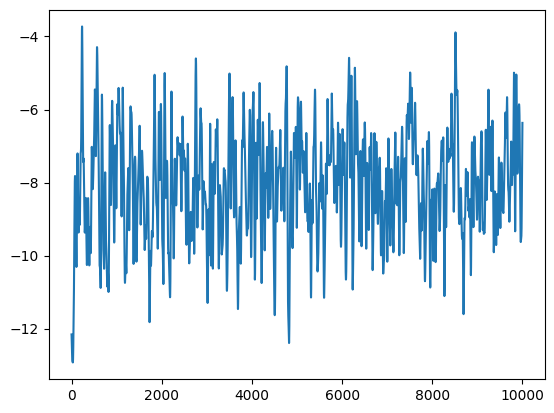

In [9]:
tr_results = run_qlearner(episodesT, 0.2, epsilon=0.1, alpha=0.1)[1]
plt.plot(gaussian_filter1d(tr_results, 10))

In [10]:
np.mean(tr_results)

-8.0725

In [11]:
agent1.q_table

array([[-2.32484908, -2.38617947, -0.83333773, -3.5958733 , -2.54810484,
        -3.54899952, -3.443223  ],
       [-4.08018527, -1.7178521 , -3.26360468, -3.78288148, -3.79312387,
        -3.57435776, -3.15142664],
       [-3.99509817, -3.31502612, -3.12876436, -3.76418259, -4.8101685 ,
        -4.62716317, -4.60266592],
       [-2.8209174 , -3.21666678, -3.09379962, -3.48333839, -1.8783356 ,
        -4.57589694, -4.55196342]])

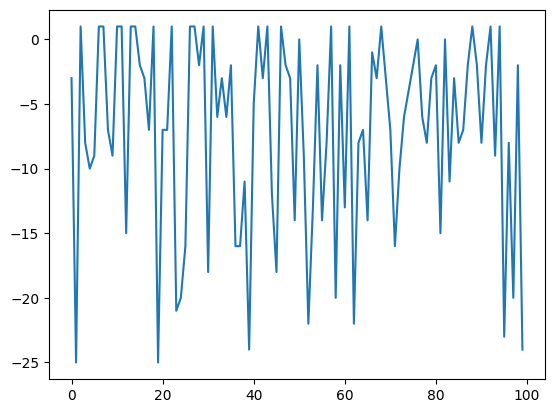

In [13]:
plt.plot(run_qlearner(100, 0.2, epsilon=0.1, alpha=0.1, train=False, agent=agent1)[1])

In [15]:
runs = 1000
episodes = 100

rQ02, rQ04, rQ06, rCurr = np.empty((episodes, runs)), np.empty((episodes, runs)), np.empty((episodes, runs)), np.empty((episodes, runs))
for i in tqdm(range(runs)):
    rCurr[:, i] = run_policy(episodes)[0]
    rQ02[:, i] = run_qlearner(episodes, 0.2, epsilon=0.1, alpha=0.1, train=False, agent=agent1)[1]
    rQ04[:, i] = run_qlearner(episodes, 0.2, epsilon=0.1, alpha=0.1, train=False, agent=agent2)[1]
    rQ06[:, i] = run_qlearner(episodes, 0.2, epsilon=0.1, alpha=0.1, train=False, agent=agent3)[1]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
rQ02.shape

(100, 1000)

In [17]:
np.apply_along_axis(np.mean, 1, rQ02)

array([-8.525, -7.937, -8.748, -8.261, -8.242, -7.806, -8.774, -8.16 ,
       -7.811, -8.472, -8.42 , -8.633, -8.379, -8.41 , -8.179, -8.013,
       -7.962, -8.027, -8.001, -8.489, -8.487, -8.455, -8.287, -8.675,
       -8.029, -8.543, -8.456, -8.383, -8.158, -8.305, -8.207, -8.542,
       -9.15 , -8.156, -8.068, -8.302, -8.461, -7.981, -8.324, -8.408,
       -8.15 , -8.388, -8.144, -8.529, -8.589, -7.591, -8.596, -8.218,
       -8.019, -8.536, -8.152, -7.758, -7.616, -8.243, -8.396, -8.552,
       -8.466, -8.045, -8.394, -8.507, -8.493, -7.569, -8.555, -8.736,
       -8.174, -8.453, -8.013, -8.237, -8.507, -8.356, -8.145, -8.33 ,
       -8.124, -8.081, -8.504, -8.373, -8.103, -8.407, -8.495, -8.529,
       -8.767, -8.376, -8.272, -8.65 , -8.584, -8.126, -7.906, -8.617,
       -8.363, -7.838, -8.535, -8.6  , -8.04 , -8.686, -8.061, -8.711,
       -8.617, -8.708, -8.546, -7.899])

In [13]:
data_eps = {'agent1': np.apply_along_axis(np.mean, 1, rQ02), 
            'agent2': np.apply_along_axis(np.mean, 1, rQ04), 
            'agent3': np.apply_along_axis(np.mean, 1, rQ06),
            'Current': np.apply_along_axis(np.mean, 1, rCurr)}
df_eps = pd.DataFrame(data=data_eps)

In [14]:
data_eps['agent3'].mean()

-7.346180000000001

In [15]:
fug = px.line(data_eps, y=['agent1', 'agent2', 'agent3', 'Current'])
fug.update_layout(xaxis_title = 'Episodes', yaxis_title = 'Average sum of reward')
fug.show()

In [18]:
# fug = px.line(data_eps, y=['Q-learner gamma=0.2', 'Q-learner gamma=0.5', 'Q-learner gamma=1'], title= 'Expected Sarsa agent run 50 times for 500 episodes with different epsilon values.')
# fug.update_layout(xaxis_title = 'Episodes', yaxis_title = 'Average sum of reward')
# fug.show()

In [19]:
data_eps

{'agent1': array([-8.557, -8.353, -8.403, -8.304, -8.599, -8.596, -8.58 , -7.992,
        -8.136, -8.366, -8.504, -8.669, -8.41 , -8.343, -8.821, -8.647,
        -8.806, -8.418, -8.357, -8.196, -8.423, -8.519, -8.663, -8.684,
        -8.659, -9.173, -8.366, -8.156, -8.303, -7.645, -8.585, -8.842,
        -8.444, -8.474, -8.69 , -8.548, -8.478, -8.355, -8.396, -8.57 ,
        -8.702, -8.785, -8.618, -8.478, -8.334, -8.465, -8.483, -8.614,
        -8.164, -8.191, -8.475, -8.55 , -8.318, -8.327, -8.333, -8.487,
        -8.709, -8.232, -8.226, -8.54 , -8.763, -8.042, -8.942, -8.335,
        -8.534, -8.14 , -8.675, -8.617, -8.216, -8.23 , -8.564, -8.852,
        -8.891, -8.379, -8.3  , -8.754, -8.816, -8.385, -8.289, -8.28 ,
        -8.628, -8.61 , -8.565, -8.51 , -8.6  , -7.986, -8.884, -8.714,
        -8.748, -8.712, -8.417, -8.396, -8.855, -8.354, -8.476, -8.862,
        -8.262, -8.179, -8.574, -8.217]),
 'agent2': array([-7.469, -7.938, -7.54 , -7.666, -7.767, -7.196, -7.641, -7.756,
  

In [21]:
episodesT = 100000
runs = 1000
episodes = 100

rSa02, rSa04, rSa06, rCurr = np.empty((episodes, runs)), np.empty((episodes, runs)), np.empty((episodes, runs)), np.empty((episodes, runs))
agentS1, agentS2, agentS4 = run_sarsa(episodesT, 0.2, epsilon=0.1, alpha=0.1)[0], run_sarsa(episodesT, 0.2, epsilon=0.1, alpha=0.1)[0], run_sarsa(episodesT, 0.2, epsilon=0.1, alpha=0.1)[0]


for i in tqdm(range(runs)):
    rCurr[:, i] = run_policy(episodes)[0]
    rSa02[:, i] = run_sarsa(episodes, 0.2, epsilon=0.1, alpha=0.1, train=False, agent=agentS1)[1]
    rSa04[:, i] = run_sarsa(episodes, 0.2, epsilon=0.1, alpha=0.1, train=False, agent=agentS2)[1]
    rSa06[:, i] = run_sarsa(episodes, 0.2, epsilon=0.1, alpha=0.1, train=False, agent=agentS4)[1]

data_eps_s = {'Agent1': np.apply_along_axis(np.mean, 1, rSa02), 
              'Agent2': np.apply_along_axis(np.mean, 1, rSa04), 
              'Agent3': np.apply_along_axis(np.mean, 1, rSa06),
              'Current': np.apply_along_axis(np.mean, 1, rCurr)}
df_eps_s = pd.DataFrame(data=data_eps)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
data_eps_s['Agent3'].mean()

-7.82487

In [23]:
fog = px.line(data_eps_s, y=['Agent1', 'Agent2', 'Agent3', 'Current'])
fog.update_layout(xaxis_title = 'Episodes', yaxis_title = 'Average sum of reward')
fog.show()

In [ ]:
agentS3 #Beste tot nu toe

In [145]:
# Find good epsilon for sarsa and extended sarsa
# searchspace epsilon: 0.01, 0.1, 0.3
episodesT = 10000
runs = 1000
episodes = 100

rS4, rS5, rS6 = np.empty((episodes, runs)), np.empty((episodes, runs)), np.empty((episodes, runs))
agentS4, agentS5, agentS6 = run_sarsa(episodesT, 0.2, epsilon=0.1, alpha=0.1)[0], run_sarsa(episodesT, 0.2, epsilon=0.1, alpha=0.1)[0], run_sarsa(episodesT, 0.2, epsilon=0.1, alpha=0.1)[0]

for i in tqdm(range(runs)):
    rS02[:, i] = run_sarsa(episodes, 0.2, epsilon=0.1, alpha=0.1,train=False, agent=agentS4)[1]
    rS05[:, i] = run_sarsa(episodes, 0.2, epsilon=0.1, alpha=0.1,train=False, agent=agentS5)[1]
    rS1[:, i] = run_sarsa(episodes, 0.2, epsilon=0.1, alpha=0.1,train=False, agent=agentS6)[1]


data_eps = {'SARSA eps=0.01': np.apply_along_axis(np.mean, 1, rS02), 'SARSA eps=0.1': np.apply_along_axis(np.mean, 1, rS05), 'SARSA eps=0.2': np.apply_along_axis(np.mean, 1, rS1)}
df_eps = pd.DataFrame(data=data_eps)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [146]:
fug = px.line(data_eps, y=['SARSA eps=0.01', 'SARSA eps=0.1', 'SARSA eps=0.2'], title= 'Q-learning agent run 1 times for 100000 episodes with different epsilon values.')
fug.update_layout(xaxis_title = 'Episodes', yaxis_title = 'Average sum of reward')
fug.show()

In [164]:
# Run all three agents with different gamma's
# searchspace gamma: 0.5, 0.9, 1

episodes = 100
runs = 10000

rewrand, rewcurr, rS1, rQ1 = np.empty((episodes, runs)), np.empty((episodes, runs)),np.empty((episodes, runs)),np.empty((episodes, runs))

for i in tqdm(range(runs)):
    rewrand[:,i] = run_random(episodes)[1]
    rewcurr[:,i] = run_policy(episodes)[0]
    rS1[:,i] = run_sarsa(episodes, 0.2, 0.1, 0.1,False, agentS3)[1]
    rQ1[:,i] = run_qlearner(episodes, 0.2, 0.1, 0.1,False, agent3)[1]

data = {'Random_learner': np.apply_along_axis(s.mean, 1, rewrand),
        'Current Policy': np.apply_along_axis(s.mean, 1, rewcurr), 
        'SARSA': np.apply_along_axis(s.mean, 1, rS1), 
         'Q-Learning': np.apply_along_axis(s.mean, 1, rQ1)}
df_rewards = pd.DataFrame(data=data)



  0%|          | 0/10000 [00:00<?, ?it/s]

In [166]:
sarsa_avg = sum(rS1)/len(rS1)

In [167]:
sarsa_avg = sum(sarsa_avg)/len(sarsa_avg)

In [168]:
sarsa_avg

-7.274878000000013

In [169]:
q_learning_avg = sum(rQ1)/len(rQ1)

In [170]:
q_learning_avg = sum(q_learning_avg)/len(q_learning_avg)

In [171]:
q_learning_avg

-7.265727000000009

In [172]:
currAvg = sum(rewcurr)/len(rewcurr)

In [173]:
currAvg = sum(currAvg)/len(currAvg)

In [174]:
currAvg

-7.342489000000008

In [175]:
randAvg = sum(rewrand)/len(rewrand)
randAvg = sum(randAvg)/len(randAvg)
print(randAvg)

-11.924883000000017


In [176]:
from scipy import stats

In [177]:
tstat, pvalue = stats.f_oneway(df_rewards['SARSA'], df_rewards['Q-Learning'], df_rewards['Current Policy'])

In [178]:
pvalue

2.9173668731208843e-12

In [179]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [180]:
data = {'SARSA': df_rewards['SARSA'],
        'Q-Learning': df_rewards['Q-Learning'],
        'Current Policy': df_rewards['Current Policy']}

# Convert the dictionary to a Pandas DataFrame
df_test = pd.DataFrame(data)

# Reshape the DataFrame to have a single column of values and a column of group labels
values = df_test.melt(var_name='Group', value_name='Score')

# Perform the Tukey HSD test
tukey_results = pairwise_tukeyhsd(values['Score'], values['Group'])

print(tukey_results)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
    group1       group2   meandiff p-adj  lower  upper  reject
--------------------------------------------------------------
Current Policy Q-Learning   0.0768    0.0 0.0509 0.1027   True
Current Policy      SARSA   0.0676    0.0 0.0417 0.0935   True
    Q-Learning      SARSA  -0.0092 0.6833 -0.035 0.0167  False
--------------------------------------------------------------


In [14]:
agentS2.q_table

array([[-1.05541371,  0.57759763, 10.        , -1.12279872, -1.39791582,
        -3.03000177, -4.02560062],
       [-2.17114391, -2.15235733, -1.48480095, -2.15901497, -2.47812953,
        -3.81126339, -3.27486318],
       [-2.7591656 , 10.        , -0.46347591, -2.57605366, -2.52540645,
        -3.7513646 , -3.39755531],
       [-2.36791116, 10.        , -2.021408  , -2.63414782, -1.58373172,
        -2.99641452, -4.50958718]])

In [19]:
agent2.q_table

array([[-1.96817178, 10.        ,  0.27365952, -1.50537147, -1.53720491,
        -1.74765305, -4.27192467],
       [-2.6595106 , -1.37285497, -0.7420525 , -2.88691017, -3.00109942,
        -3.0345435 , -2.89415986],
       [-3.20899088, 10.        , -3.28611872, -3.19836204, -4.08268211,
        -3.94004263, -4.01054699],
       [-2.45399709, -2.17562865,  0.50216059, -2.36089987, -2.98817172,
        -3.020374  , -3.76766275]])

In [94]:
max(agent2.q_table[3])

-1.037352858246682

In [81]:
data = {'Random_learner': np.apply_along_axis(s.mean, 1, rewrand),
        'Current Policy': np.apply_along_axis(s.mean, 1, rewcurr), 
        'SARSA': np.apply_along_axis(s.mean, 1, rS1), 
         'Q-Learning': np.apply_along_axis(s.mean, 1, rQ1)}
df_rewards = pd.DataFrame(data=data)

In [165]:
fog = px.line(df_rewards, y = ['Random_learner', 'Current Policy', 'SARSA', 'Q-Learning'], title='Random agent, Sarsa agent and Q-learning agent run {r} times for {e} episodes with gamma = 0.2'.format(r = runs, e = episodes))
fog.update_layout(xaxis_title='Episodes', yaxis_title='Average sum of reward')
fog.show()

In [181]:
sarsa_most_frequent_patterns = run_sarsa(100000, 1, 1, 1, False, agentS3, True)[2]

In [182]:
from collections import Counter

sarsaCounts = Counter(sarsa_most_frequent_patterns)

In [183]:
sarsaCounts.most_common(10)

[("(1, 'va', 'Tau')", 5173),
 ("(2, 'sib', 'Tau')", 5000),
 ("(1, 'pp', 'Tau')", 4664),
 ("(1, 'po', 'Tau')", 4547),
 ("(2, 'sib', 'sib')(2, 'sib', 'Tau')", 2882),
 ("(1, 'pp', 'pp')(1, 'pp', 'Tau')", 2652),
 ("(1, 'va', 'va')(1, 'va', 'Tau')", 2189),
 ("(1, 'po', 'pp')(1, 'pp', 'Tau')", 1603),
 ("(1, 'pp', 'pp')(1, 'pp', 'pp')(1, 'pp', 'Tau')", 1520),
 ("(2, 'sib', 'sib')(2, 'sib', 'sib')(2, 'sib', 'Tau')", 1507)]

In [184]:
qlearning_most_freq = run_qlearner(100000, 1, 1, 1, False, agent3, True)[2]

In [185]:
qlearningCounts = Counter(qlearning_most_freq)

In [186]:
qlearningCounts.most_common(10)

[("(1, 'va', 'Tau')", 5207),
 ("(2, 'sib', 'Tau')", 4901),
 ("(1, 'po', 'Tau')", 4661),
 ("(1, 'pp', 'Tau')", 4620),
 ("(1, 'pp', 'pp')(1, 'pp', 'Tau')", 2749),
 ("(2, 'sib', 'sib')(2, 'sib', 'Tau')", 2720),
 ("(1, 'va', 'va')(1, 'va', 'Tau')", 2302),
 ("(1, 'po', 'pp')(1, 'pp', 'Tau')", 1602),
 ("(1, 'pp', 'pp')(1, 'pp', 'pp')(1, 'pp', 'Tau')", 1596),
 ("(2, 'sib', 'sib')(2, 'sib', 'sib')(2, 'sib', 'Tau')", 1576)]

In [187]:
currentpolicy_freq = run_policy(100000, True)[1]

In [188]:
cpCounts = Counter(currentpolicy_freq)

In [189]:
cpCounts.most_common(10)

[("(1, 'va', 'Tau')", 5052),
 ("(1, 'sib', 'Tau')", 4772),
 ("(1, 'pp', 'Tau')", 4520),
 ("(1, 'po', 'Tau')", 4488),
 ("(1, 'pp', 'pp')(1, 'pp', 'Tau')", 2617),
 ("(1, 'va', 'va')(1, 'va', 'Tau')", 2337),
 ("(1, 'sib', 'sib')(1, 'sib', 'Tau')", 1776),
 ("(1, 'po', 'pp')(1, 'pp', 'Tau')", 1676),
 ("(1, 'pp', 'pp')(1, 'pp', 'pp')(1, 'pp', 'Tau')", 1593),
 ("(1, 'po', 'po')(1, 'po', 'Tau')", 1219)]

In [190]:
randpol_freq = run_random(100000, True)[2]

In [191]:
rpCounts = Counter(randpol_freq)

In [192]:
rpCounts.most_common(10)

[("(6, 'sib', 'Tau')", 976),
 ("(2, 'va', 'Tau')", 884),
 ("(5, 'va', 'Tau')", 861),
 ("(4, 'va', 'Tau')", 757),
 ("(1, 'va', 'Tau')", 747),
 ("(5, 'sib', 'Tau')", 740),
 ("(3, 'sib', 'Tau')", 713),
 ("(3, 'po', 'Tau')", 693),
 ("(0, 'va', 'Tau')", 692),
 ("(4, 'pp', 'Tau')", 691)]

# BELOW ONLY GRAPHS

In [22]:
fig = px.line(df_rewards, y = ['Sarsa 0.5', 'Sarsa 0.9', 'Sarsa 1'], title= 'Sarsa agent run {r} times for {e} episodes with different gamma values.'.format(r = runs, e = episodes))
fig.update_layout(xaxis_title='Episodes', yaxis_title='Average sum of reward')
fig.show()

In [23]:
fig = px.line(df_rewards, y = ['Q 0.5', 'Q 0.9', 'Q 1'], title='Q-learning agent run {r} times for {e} episodes with different gamma values.'.format(r = runs, e = episodes))
fig.update_layout(xaxis_title='Episodes', yaxis_title='Average sum of reward')
fig.show()

In [ ]:
fug = px.line(df_rewards, y = ['ES 0.5', 'ES 0.9', 'ES 1'], title='Expected Sarsa agent run {r} times for {e} episodes with different gamma values.'.format(r = runs, e = episodes))
fug.update_layout(xaxis_title='Episodes', yaxis_title='Average sum of reward')
fug.show()

In [28]:
fog = px.line(df_rewards, y = ['Random_learner', 'Current Policy', 'SARSA', 'Q-Learning'], title='Random agent, Sarsa agent and Q-learning agent run {r} times for {e} episodes with gamma = 0.2'.format(r = runs, e = episodes))
fog.update_layout(xaxis_title='Episodes', yaxis_title='Average sum of reward')
fog.show()